# Reinforcement Learning Tic-Tac-Toe

In this document, I will show what I have done to test my environment and evaluate it. This includes the feedback I received from other students and teachers, which I have tried to implement in the document.

The reason I created Tic-Tac-Toe is because I am planning to make a 9x9 Atari Go model that can help people learn how to take and hold territory. This is the premise of Atari Go compared to regular Go.

Let's load in the libraries and classes so we can begin.

In [15]:
import numpy as np
import pandas as pd
# from Tick_tack_toe_env import TicTacToeEnv
# from Tick_tack_toe_env_2 import TicTacToeEnv
from Tick_tack_toe_env_3 import TicTacToeEnv
# from Tick_tack_toe_agent import Tick_tack_toe_agent
from Tick_tack_toe_agent_2 import Tick_tack_toe_agent
import matplotlib.animation as animation
from IPython.display import HTML, display
from datetime import datetime
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import csv
import os
import ast

Below, I set up some basic settings and variables. For instance, whether I want a live game view or not, the minimal exploration rate, the exploration decay, and the learning rate.

After setting these, I also show the environment shape to make sure everything is correct.

In [16]:
if False:
    enviremnt = TicTacToeEnv(simulations=100, random_monte_carlo=False, render_mode="human")
else:
    enviremnt = TicTacToeEnv(simulations=100, random_monte_carlo=False, draw_reward=0.75)

episodes = 2000
exploitation_episodes = 20
target_update_freq =  50
max_rounds_in_episode = 9

min_exploration = 0.01

exploration_decay = 1 - (((1 / min_exploration) * 0.02) / (episodes - exploitation_episodes))


parameters = { 
    'use_pretrained': True,
    'training_data_path': None , # './tic_tac_toe_training_data/train_data.csv',
    # 'model_path': './output_models/base_models/9x9_Go_low_dropout_2025-06-08_13-16.h5',
    'model_path': './output_models/tic_tac_too_2025-06-24_08-32.h5',
    'min_exploration_rate': min_exploration, 
    'exploration_decay': exploration_decay,
    'learning_rate': 0.001,
    'track_tracemallox': False,
    'Logging': True,
    'random_monte_carlo': False
    }

print("training shape: ", enviremnt.observation_space)

training shape:  Box(-1, 1, (3, 3, 5), int32)


Now I will create my agent for training on the environment. This means I create a model that will learn from its past interactions with the system. As of writing this, I am using a CNN backbone with two standard Conv2D layers (with additional layers to clean up after flattening and BatchNormalization) and two residual blocks. If you want to learn more about residual blocks, you can find information [here](https://en.wikipedia.org/wiki/Residual_neural_network). If implemented correctly, I have created a `Pre-activation block`. Basically, a residual block inside a CNN model helps clarify parts of the input for the model, enabling it to make better complex decisions.

The creation of the agent returns its model sizes; they should be the same, as one is used for training and the other is the historical version of itself that gets updated every X number of episodes, based on `target_update_freq`.

Below the initialization of the agent, we create variables for debugging, validation, and plotting during training.

In [17]:
agent = Tick_tack_toe_agent(enviremnt.observation_space, enviremnt.action_space.n, **parameters)
reward_history = []
exploration_per_episode = []
loss_per_episode = []
accuracy_per_episode = []
avg_reward_per_episode = []
terminated_per_episode = []
truncated_per_episode = []
steps_made_in_episodes = []

Pretrained model loaded from ./output_models/tic_tac_too_2025-06-24_08-32.h5
Model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 3, 5)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 3, 3, 10)     460         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 3, 3, 10)    40          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 d

And because I received feedback and wanted to make the workflow more integrated, I created a plotting function that updates the training progress plot in real time.

This function should be called at the appropriate points during training. If you look at the training block, you can see that the function is called to update the plot, using the display handle created when the plot is first set up. This allows for live visualization of training metrics as the agent learns.

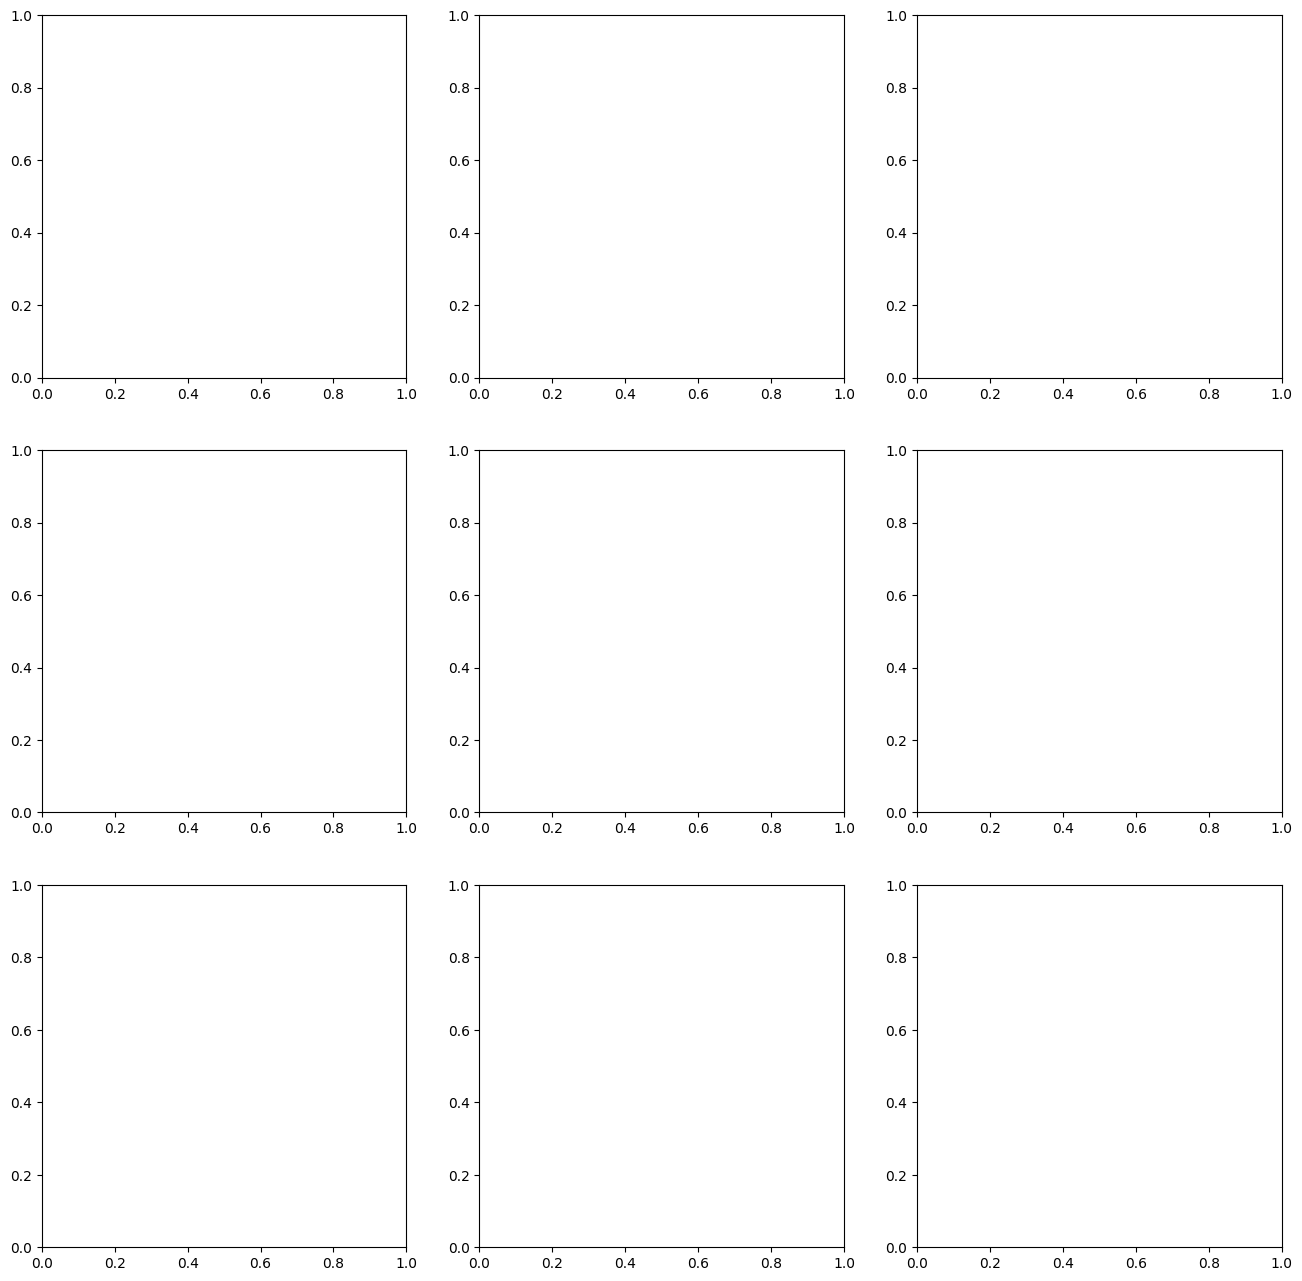

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axs.flat



def plot_progress(window_rolling = 30):
    episodes_range = range(1, len(reward_history) + 1)

    # Total Reward
    df_reward = pd.Series(reward_history)
    ma_reward_history = df_reward.rolling(window=window_rolling).mean()

    ax1.clear()
    ax1.plot(df_reward, label='Raw', color="lightblue")
    ax1.plot(ma_reward_history, label='Avg Reward', color='red')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.legend()
    ax1.set_title('Total Reward per Episode')

    # Exploration Rate
    ax2.clear()
    ax2.plot(episodes_range, exploration_per_episode, label='Exploration Rate', color='orange')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Exploration Rate')
    ax2.set_title('Exploration Rate per Episode')

    # Loss
    df_loss = pd.Series(loss_per_episode)
    ma_loss = df_loss.rolling(window=window_rolling).mean()

    ax3.clear()
    ax3.plot(df_loss, label='Raw', color='lightgreen')
    ax3.plot(ma_loss, label='Avg Loss', color='red')
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.set_title('Average Loss')

    # Steps per episode
    df_steps = pd.Series(steps_made_in_episodes)
    ma_steps = df_steps.rolling(window=window_rolling).mean()

    ax4.clear()
    ax4.plot(df_steps, label='Raw', color='cyan')
    ax4.plot(ma_steps, label='Avg Steps', color='red')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Steps')
    ax4.legend()
    ax4.set_title('Steps per Episode')

    # accuracy per episode
    df_accuracy = pd.Series(accuracy_per_episode)
    ma_accuracy = df_accuracy.rolling(window=window_rolling).mean()

    ax5.clear()
    ax5.plot(df_accuracy, label='Raw', color='gold')
    ax5.plot(ma_accuracy, label='Avg accuracy', color='red')
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('accuracy')
    ax5.legend()
    ax5.set_title('Average accuracy')
    
    # Terminated
    df_terminated = pd.Series(terminated_per_episode)
    ma_terminated = df_terminated.rolling(window=window_rolling).mean()
    
    ax6.clear()
    ax6.plot(df_terminated, label='Raw', color='royalblue')
    ax6.plot(ma_terminated, label='Avg terminated', color='red')
    ax6.set_xlabel('Episode')
    ax6.set_ylabel('Terminated')
    ax6.legend()
    ax6.set_title('Terminated per Episode')

    # Truncated
    df_truncated = pd.Series(truncated_per_episode)
    ma_truncated = df_truncated.rolling(window=window_rolling).mean()
    
    ax7.clear()
    ax7.plot(df_truncated, label='Raw', color='violet')
    ax7.plot(ma_truncated, label='Avg truncated', color='red')
    ax7.set_xlabel('Episode')
    ax7.set_ylabel('Truncated')
    ax7.legend()
    ax7.set_title('Truncated per Episode')

    plt.tight_layout()


And I also wanted to log the entire training in an easier-to-read format, and possibly also recreate a game.

In [19]:
path = "./logs"
os.makedirs(path, exist_ok=True)

Now that I have checked that the log directory exists, I open a log file to write to. Then, I go through the training loop, which runs for the predetermined `episodes` value.

In the loop, the agent learns from previously encountered state-action combinations. If the episode is truncated (which only happens when an illegal move is made in the environment), a large negative reward is given to discourage such actions.

After each episode, I save all the important information from the episode to the log file.

Every `target_update_freq` episodes, I update the plot and the displayed image to show training progress, and I update the target model.


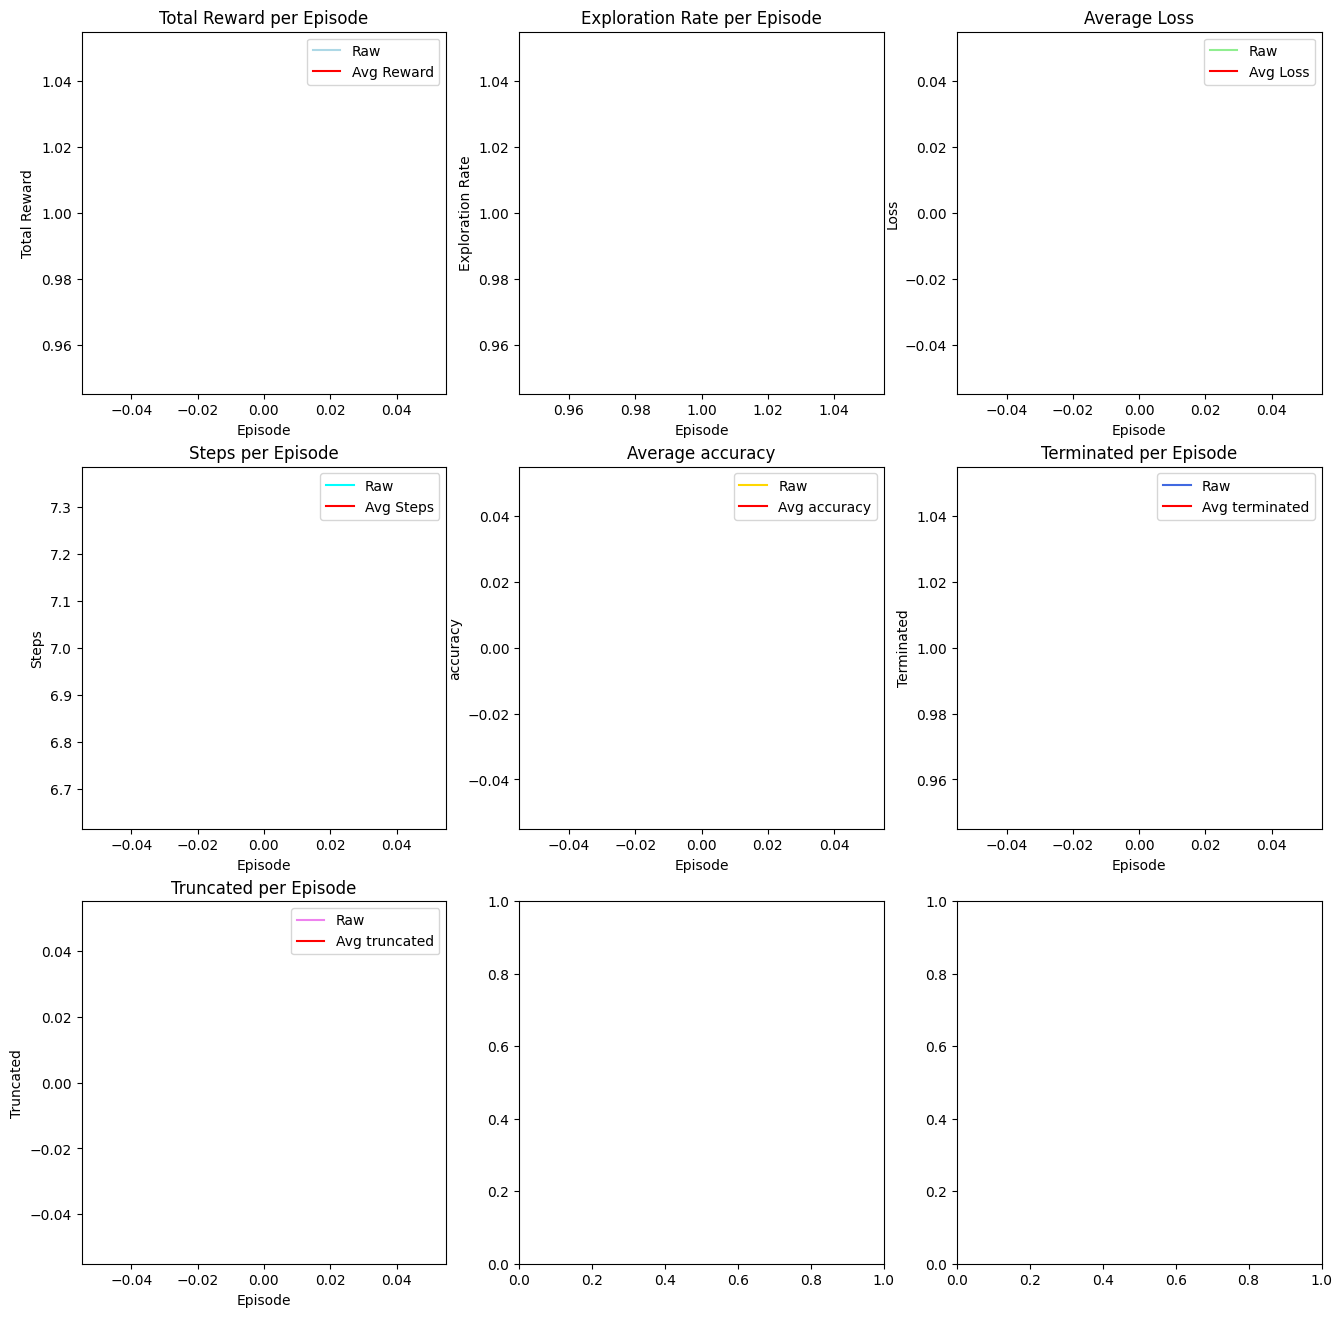

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

c:\Users\super\anaconda3\envs\Personal_chalange\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\super\anaconda3\envs\Personal_chalange\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [14]:
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_path = os.path.join(path, f"training_log_{current_time}.csv")
if agent.logging: 
    display_handle = display(fig, display_id=True)

with open(log_path, mode="w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["episode", "step", "state", "action", "reward", "terminated", "truncated"])
    writer.writeheader()
    

    for episode in trange(episodes, desc="Training"):
        state, info = enviremnt.reset()
        terminated = False
        truncated = False
        total_reward = 0
        steps_in_episode = 0

        while (not terminated and not truncated) and steps_in_episode < max_rounds_in_episode:
            action = agent.act(state)

            next_state, reward, terminated, truncated, info = enviremnt.step(action)
            enviremnt.render()
            
            total_reward += reward

            if truncated:
                reward = -1
            

            agent.remember(state, action, reward, next_state, terminated, truncated)
            
            agent.replay()

            writer.writerow({
                "episode": episode,
                "step": steps_in_episode,
                "state": state.tolist(),
                "action": action,
                "reward": reward,
                "terminated": terminated,
                "truncated" : truncated
            })

            steps_in_episode += 1
            state = next_state

        if agent.logging:
            reward_history.append(total_reward)
            exploration_per_episode.append(agent.exploration_rate)
            loss_per_episode.append(np.mean(agent.loss_history[-(steps_in_episode * agent.batch_size):]))
            accuracy_per_episode.append(np.mean(agent.accuracy_history[-(steps_in_episode * agent.batch_size):]))
            terminated_per_episode.append(terminated)
            truncated_per_episode.append(truncated)
            steps_made_in_episodes.append(steps_in_episode)

        if episode % target_update_freq == 0:
            agent.update_target_model()
            agent.tracemalloc_data()
            if agent.logging:
                plot_progress()  
                display_handle.update(fig)

enviremnt.close()
if agent.logging:
    plot_progress()  
    display_handle.update(fig)

Here I save the model after updating the target model one last time.  
This is done by specifying the folder and the name it should take (the name is given without the extension, as it will always be saved as a `.h5` file).

In [ ]:
# agent.update_target_model()
agent.save_models("./output_models", f"tic_tac_too_{current_time}", False)

Model saved in HDF5 format at: ./output_models\tic_tac_too_2025-06-24_08-32.h5


# look back code

The function below creates an animated video of a Tic-Tac-Toe game based on a given DataFrame. This function is specifically designed for this use case, where each row in the DataFrame represents a step in the game, including the board state and the action taken.

It visualizes the board at each step, placing 'X' and 'O' in their correct positions according to the state information. The most recent move is highlighted as the board updates, allowing you to follow the progression of the game step by step.

This visualization is useful for reviewing and analyzing the agent's decisions during training or evaluation, making it easier to understand how the model plays and learns over time.

In [ ]:
def plot_board_vid(df):
    """
    Plots a 2D board video for tic_tac_toe.
    'X' is placed where state[:, :, 0] == 1
    'O' is placed where state[:, :, 2] == 1
    """

    size = 3
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, size - 0.5)
    ax.set_ylim(-0.5, size - 0.5)
    ax.set_aspect('equal')
    ax.set_xticks(range(size))
    ax.set_yticks(range(size))
    ax.grid(True)

    play_patches = []

    def update(frame_index):
        # Remove previous text patches
        for patch in play_patches:
            patch.remove()
        play_patches.clear()

        state = np.array(ast.literal_eval(df.iloc[frame_index]["state"]))
        action = df.iloc[frame_index]["action"]

        plane_x = state[:, :, 0]
        plane_o = state[:, :, 2]

        for i in range(3):
            for j in range(3):
                if plane_x[i, j] == 1:
                    txt = ax.text(j, 2 - i, "X", ha='center', va='center', fontsize=20, color="blue")
                    play_patches.append(txt)
                elif plane_o[i, j] == 1:
                    txt = ax.text(j, 2 - i, "O", ha='center', va='center', fontsize=20, color="red")
                    play_patches.append(txt)

        row, col = divmod(action, 3)
        player = state[0, 0, 4]
        if player == 0:
            txt = ax.text(col, 2 - row, "X", ha='center', va='center', fontsize=20, color="blue")
        else:
            txt = ax.text(col, 2 - row, "O", ha='center', va='center', fontsize=20, color="red")
        play_patches.append(txt)

    ani = animation.FuncAnimation(
        fig, update, frames=len(df), interval=800, repeat=True
    )
    plt.close(fig)  # Prevent double display in notebooks
    return HTML(ani.to_jshtml())

In this section, I specify the range of episodes I want to review by setting the `from_episode` and `to_episode` variables. I then load the training log data from the CSV file and filter it to include only the selected episodes.

For each episode in this range, I extract the relevant steps, sort them in order, and generate an animated visualization of the game using the `plot_board_vid` function.

Additionally, I print out detailed step-by-step information for each move within the episode, including the state, action, reward, and whether the episode was terminated or truncated. This helps in analyzing the agent's decision-making process and understanding its learning progress.

In [ ]:
to_episode = episodes
from_episode = to_episode -10

df = pd.read_csv(log_path)

filtered_df = df[(df["episode"] >= from_episode) & (df["episode"] <= to_episode)]

episode_ids = filtered_df["episode"].unique()

for episode_id in episode_ids:
    episode_data = filtered_df[filtered_df["episode"] == episode_id]
    
    episode_data = episode_data.sort_values(by=["step"])
    
    print(f"\nEpisode {episode_id}:")
    
    html_anim = plot_board_vid(episode_data)
    display(html_anim)
    
    for _, row in episode_data.iterrows():
        step = row["step"]
        print(f"  Step {step}: {row.to_dict()}")


Episode 1990:


  Step 0: {'episode': 1990, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 7, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1990, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 0, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1990, 'step': 2, 'state': '[[[0, 0, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 1, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1990, 'step': 3, 'state': '[[[0, 0, 1, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1991, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 7, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1991, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1991, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 5, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1991, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 1, 0, 1], [1, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1992, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 7, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1992, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1992, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 3, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1992, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[1, 0, 0, 0, 1], [0, 0, 1, 0, 1], [0, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1993, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 7, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1993, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 5, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1993, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1993, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 1, 0, 1]], [[0,

  Step 0: {'episode': 1994, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 7, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1994, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 0, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1994, 'step': 2, 'state': '[[[0, 0, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 8, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1994, 'step': 3, 'state': '[[[0, 0, 1, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1995, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1995, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 8, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1995, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0]]]', 'action': 5, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1995, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 1, 0, 0, 1], [1, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1996, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 8, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1996, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [1, 0, 0, 0, 1]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1996, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [1, 0, 0, 0, 0]]]', 'action': 1, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1996, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 1, 0, 1], [0, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1997, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1997, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 1, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1997, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 5, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1997, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 1, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 1, 0, 0, 1], [1, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1998, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 7, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1998, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 3, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1998, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 1, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1998, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 1, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0,

  Step 0: {'episode': 1999, 'step': 0, 'state': '[[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 1, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 1: {'episode': 1999, 'step': 1, 'state': '[[[0, 0, 0, 0, 1], [1, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 1]]]', 'action': 4, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 2: {'episode': 1999, 'step': 2, 'state': '[[[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]]]', 'action': 5, 'reward': 0.0, 'terminated': False, 'truncated': False}
  Step 3: {'episode': 1999, 'step': 3, 'state': '[[[0, 0, 0, 0, 1], [1, 1, 0, 0, 1], [0, 0, 0, 0, 1]], [[0, 0, 0, 0, 1], [0, 0, 1, 0, 1], [1, 0, 0, 0, 1]], [[0,

# human play

here i will try and play with the model itself, this will be in the pygame framework, and that doesn't work in jupyther, meaning i need to remember to take an image or video and put it in here

In [22]:
agent.start_human_play()

state, info = enviremnt.reset()
terminated = False
truncated = False
total_reward = 0
steps_in_episode = 0

while (not terminated and not truncated) and steps_in_episode < max_rounds_in_episode:
    agent.render(state)
    
    if steps_in_episode % 2 == 1:
        action = agent.human_act()
    else:
        action = agent.act(state)
    
    next_state, reward, terminated, truncated, info = enviremnt.step(action)
    
    total_reward += reward

    if truncated:
        reward = -100
        
    elif terminated and steps_in_episode < (max_rounds_in_episode - 1):
        reward *= 10 

    agent.remember(state, action, reward, next_state, terminated, truncated)
    
    agent.replay()
    
    steps_in_episode += 1
    state = next_state

print(f"Total reward: {total_reward}, Steps in episode: {steps_in_episode}, Terminated: {terminated}, Truncated: {truncated}")

agent.stop_human_play()

Total reward: 1.0, Steps in episode: 7, Terminated: True, Truncated: False
